<a href="https://colab.research.google.com/github/Abhineswari/handwriting_detection/blob/main/Handwriting_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("Connect")

Connect


# Import zip file and extract.

In [ ]:
import zipfile
import os

# Path to the zip file and destination folder
zip_path = "/content/handwriting_dataset.zip"
extract_folder = "/content/handwriting_dataset"

# Extract only if the folder doesn't already exist
if not os.path.exists(extract_folder):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print("✅ Dataset successfully extracted!")
else:
    print("📝 Dataset folder already exists, skipping extraction.")


✅ Dataset successfully extracted!


# DATA HANDLING, SPLIT INTO TEST AND TRAIN

In [ ]:
#DATA HANDLING

import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
image_folder = "/content/handwriting_dataset"
output_folder = "/content/split_dataset"

# Get class folders
class_names = sorted([d for d in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, d))])

# Collect images and labels
images = []
labels = []

for class_name in class_names:
    class_path = os.path.join(image_folder, class_name)
    for img_file in os.listdir(class_path):
        if img_file.endswith('.jpg'):
            images.append(os.path.join(class_path, img_file))
            labels.append(class_name)

# Split images into train and test
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

# Function to move images into train/test folders
def organize_split(images, labels, split_type):
    for img, label in zip(images, labels):
        split_folder = os.path.join(output_folder, split_type, label)
        os.makedirs(split_folder, exist_ok=True)
        shutil.copy(img, os.path.join(split_folder, os.path.basename(img)))

# Organize train and test
organize_split(train_images, train_labels, 'train')
organize_split(test_images, test_labels, 'test')

print("✅ Dataset successfully split and organized into class-specific folders!")


✅ Dataset successfully split and organized into class-specific folders!


# TRAIN MODEL

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import os

# Paths
train_dir = "/content/split_dataset/train"
test_dir = "/content/split_dataset/test"

# Image size (fixed at 224x224 for MobileNetV2)
batch_size = 16
img_size = (224, 224)

# Function to Crop Handwriting Region
def crop_handwriting_region(image):
    """ Crops the handwriting region of an image by detecting contours. """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale

    # 🔹 Convert to uint8 (Fix OpenCV error)
    gray = (gray * 255).astype(np.uint8)

    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)  # Thresholding

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))  # Find largest contour
        cropped = image[y:y+h, x:x+w]  # Crop the handwriting region
        cropped = cv2.resize(cropped, (224, 224))  # Resize to MobileNetV2 size
    else:
        cropped = cv2.resize(image, (224, 224))  # If no handwriting, just resize

    return cropped  # ✅ FIXED: No extra stacking



# Custom Data Generator (Fix: Applies Cropping Correctly)
class CustomDataGenerator(Sequence):
    def __init__(self, generator):
        self.generator = generator

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        batch_x, batch_y = self.generator[index]
        batch_x = np.array([crop_handwriting_region(img) for img in batch_x])
        return batch_x, batch_y

# Use ImageDataGenerator for Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load datasets
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)
train_dataset = CustomDataGenerator(train_gen)

# Normalization for test dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)
test_dataset = CustomDataGenerator(test_gen)

# Save class names from DirectoryIterator
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)
print("Class names:", class_names)
print("Number of classes:", num_classes)

# Load MobileNetV2 without the top layer and freeze the base
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the convolutional base

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10
)


# Save the model
model.save('/content/handwriting_model_mobilenetv2.h5')

# Get final accuracy and validation accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\n📊 Final Training Accuracy: {final_train_acc:.4f}")
print(f"📊 Final Validation Accuracy: {final_val_acc:.4f}")

print("\n✅ Model trained and saved successfully with MobileNetV2! 🚀")

Found 79 images belonging to 11 classes.
Found 20 images belonging to 11 classes.
Class names: ['Abhineswari', 'Angela', 'Helan', 'Huda', 'Jahnavi', 'Jessica', 'Juliet', 'Jyothis', 'Madhu', 'Shreya', 'Supreeth']
Number of classes: 11
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.0866 - loss: 3.1023 - val_accuracy: 0.1500 - val_loss: 2.5090
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.1531 - loss: 2.7129 - val_accuracy: 0.2500 - val_loss: 2.4077
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2171 - loss: 2.5793 - val_accuracy: 0.1500 - val_loss: 2.3427
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2180 - loss: 2.6649 - val_accuracy: 0.2500 - val_loss: 2.2996
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1584 - loss: 2.5397 - val_accuracy: 0.3000 - val_loss: 2.2580
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.1337 - loss: 2.7538 - val_accuracy: 0.3000 - val_loss: 2.1956
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2367 - loss: 2.4442 - val_accuracy: 0.2500 - val_loss: 2.1336
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3232 - loss: 2.2127 - val_accuracy: 0.3500 - val_loss: 2.0765
Epoch 9/10
5/5 


📊 Final Training Accuracy: 0.2532
📊 Final Validation Accuracy: 0.3500

✅ Model trained and saved successfully with MobileNetV2! 🚀


#PREDICTION

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


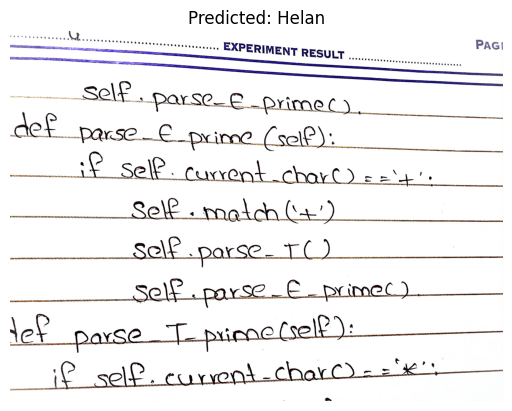

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2

# Load the trained model
model = load_model('/content/handwriting_model_mobilenetv2.h5')

# Function to preprocess a test image
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = crop_handwriting_region(img)  # Apply handwriting region cropping
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Test on a sample image
random_image_path = "/content/handwriting_dataset/Madhu/Madhu_3.jpg"
img_array = preprocess_image(random_image_path)

# Predict
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

# Show the image and prediction
plt.imshow(cv2.imread(random_image_path))
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()
